In [1]:
# notebooks/create_scenarios.ipynb

from scripts.create_data import create_data_scenario
from scripts.logger import log_scenario_folder, mark_log_as_finished
import random
from datetime import datetime
from scripts.logger import create_new_id
import os

# Initialize logging ID
logs_id = create_new_id("scenario")

# Define logging inputs
logging_inputs = {
    "num_scenarios": 1000,
    "aircraft_range": (3, 3),
    "amount_aircraft_disrupted": 1,
    "amount_aircraft_uncertain": 1,
    "average_flights_per_aircraft": 12,
    "std_dev_flights_per_aircraft": 1,
    "min_delta_start_unavailability": 120,
    "max_delta_start_unavailability": 480,
    "min_period_unavailability": 120,
    "max_period_unavailability": 480,
    "probability_range": (0.5, 0.9),
    "probability_distribution": 'uniform',
    "clear_one_random_aircraft": True,
    "clear_random_flights": True,
    "switch_one_random_flight_to_the_cleared_aircraft": True,
    "first_flight_dep_time_range": (6, 8),
    "flight_length_range": (2, 5),
    "time_between_flights_range": (0, 1),
}

# Fixed inputs
template_folder = "../data/Template"
data_root_folder = f"../data/Training/3ac-{logging_inputs['num_scenarios']}-steady/"
airports = [
    'AMS', 'CDG', 'FRA', 'LHR', 'MAD', 'MUC', 'ORY', 'TXL', 'VIE', 'ZRH', 
    'BCN', 'BRU', 'CPH', 'DUB', 'IST'
]
aircraft_types = [
    {'Model': 'A320', 'Family': 'Airbus', 'Config': '0/0/123', 'Dist': 5000, 'Cost/h': 1800.0, 
     'TurnRound': 30, 'Transit': 30, 'Orig': ['CFE'], 'Maint': ['NULL']}
    # Add more aircraft types if needed
]
config_dict = {
    'DelayCosts': [{'Cabin': 'Economy', 'Type': 'ShortHaul', 'Cost': 100.0}],
    'CancellationCostsOutbound': [{'Cabin': 'Economy', 'Type': 'ShortHaul', 'Cost': 500.0}],
    'CancellationCostsInbound': [{'Cabin': 'Economy', 'Type': 'ShortHaul', 'Cost': 600.0}],
    'DowngradingCosts': [{'FromCabin': 'Business', 'ToCabin': 'Economy', 'Type': 'ShortHaul', 'Cost': 200.0}],
    'PenaltyCosts': [200, 300, 400],
    'Weights': [1.0, 0.5, 0.2],
}

# Initialize outputs dictionary
logging_outputs = {}

# Function to generate scenarios
for i in range(1, logging_inputs["num_scenarios"] + 1):
    scenario_name = f'Scenario_{i:02d}'  # Dynamically generate scenario names
    recovery_start_date = datetime(2024, 9, random.randint(1, 30)).strftime('%d/%m/%y')
    recovery_start_time = f'{random.randint(5, 7)}:00'
    recovery_end_date = recovery_start_date
    recovery_end_time = f'{random.randint(20, 23)}:{random.choice(["00", "30"])}'

    # Call the function for each scenario
    data_folder, inputs, outputs = create_data_scenario(
        scenario_name=scenario_name,
        template_folder=template_folder,
        data_root_folder=data_root_folder,
        aircraft_types=aircraft_types,
        total_aircraft_range=logging_inputs["aircraft_range"],
        amount_aircraft_disrupted=logging_inputs["amount_aircraft_disrupted"],
        amount_aircraft_uncertain=logging_inputs["amount_aircraft_uncertain"],
        min_delta_start_unavailability=logging_inputs["min_delta_start_unavailability"],
        max_delta_start_unavailability=logging_inputs["max_delta_start_unavailability"],
        min_period_unavailability=logging_inputs["min_period_unavailability"],
        max_period_unavailability=logging_inputs["max_period_unavailability"],
        average_flights_per_aircraft=logging_inputs["average_flights_per_aircraft"],
        std_dev_flights_per_aircraft=logging_inputs["std_dev_flights_per_aircraft"],
        airports=airports,
        config_dict=config_dict,
        recovery_start_date=recovery_start_date,
        recovery_start_time=recovery_start_time,
        recovery_end_date=recovery_end_date,
        recovery_end_time=recovery_end_time,
        clear_one_random_aircraft=logging_inputs["clear_one_random_aircraft"],
        clear_random_flights=logging_inputs["clear_random_flights"],
        switch_one_random_flight_to_the_cleared_aircraft=logging_inputs["switch_one_random_flight_to_the_cleared_aircraft"],
        probability_range=logging_inputs["probability_range"],
        probability_distribution=logging_inputs["probability_distribution"],
        first_flight_dep_time_range=logging_inputs["first_flight_dep_time_range"],
        flight_length_range=logging_inputs["flight_length_range"],
        time_between_flights_range=logging_inputs["time_between_flights_range"],
    )

    # Add scenario outputs to logging_outputs
    logging_outputs[scenario_name] = outputs

# Define the full data_folder path (assuming all scenarios are in the same folder)
# If scenarios are in separate folders, adjust accordingly
# Here, since num_scenarios=1, it's straightforward
scenario_folder_path = os.path.join(data_root_folder, scenario_name)

# Log the scenarios
log_scenario_folder(
    logs_id=logs_id,
    scenario_folder_path=data_root_folder,
    inputs=logging_inputs,
    outputs=logging_outputs
)

# Mark the log as finished
mark_log_as_finished(logs_id, additional_info=data_root_folder)



Data creation for scenario Scenario_01 completed with 3 aircraft and 5 flights.
Data creation for scenario Scenario_02 completed with 3 aircraft and 6 flights.
Data creation for scenario Scenario_03 completed with 3 aircraft and 8 flights.
Data creation for scenario Scenario_04 completed with 3 aircraft and 6 flights.
Data creation for scenario Scenario_05 completed with 3 aircraft and 6 flights.
Data creation for scenario Scenario_06 completed with 3 aircraft and 5 flights.
Data creation for scenario Scenario_07 completed with 3 aircraft and 5 flights.
Data creation for scenario Scenario_08 completed with 3 aircraft and 7 flights.
Data creation for scenario Scenario_09 completed with 3 aircraft and 9 flights.
Data creation for scenario Scenario_10 completed with 3 aircraft and 6 flights.
Data creation for scenario Scenario_11 completed with 3 aircraft and 5 flights.
Data creation for scenario Scenario_12 completed with 3 aircraft and 5 flights.
Data creation for scenario Scenario_13 c

### Visualize them

Processing scenario: Scenario_01
{'A320#3': {'StartDate': '30/09/24', 'StartTime': '08:01', 'EndDate': '30/09/24', 'EndTime': '12:44', 'Probability': 1.0}, 'A320#2': {'StartDate': '30/09/24', 'StartTime': '08:11', 'EndDate': '30/09/24', 'EndTime': '12:09', 'Probability': 0.6}}
│ Current Time       │ Time Until End     │   
│          0         │         840        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     7   650   818 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   0.60    131   369 |     3    15   313 |     4   354   591 |     -     -     - |     -     -  

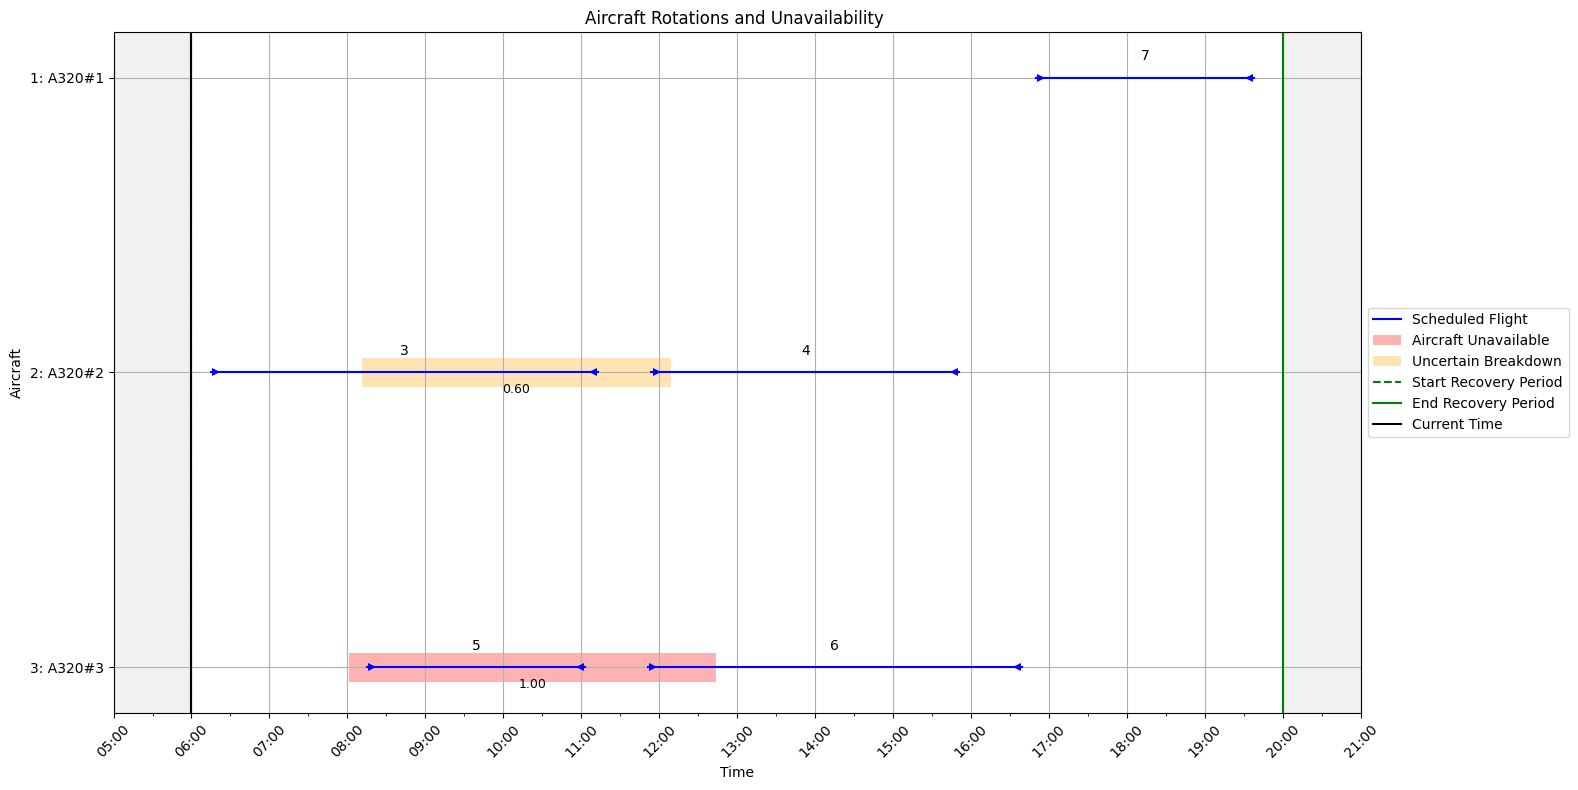

Processing scenario: Scenario_02
{'A320#3': {'StartDate': '13/09/24', 'StartTime': '08:15', 'EndDate': '13/09/24', 'EndTime': '15:16', 'Probability': 1.0}, 'A320#2': {'StartDate': '13/09/24', 'StartTime': '10:47', 'EndDate': '13/09/24', 'EndTime': '17:03', 'Probability': 0.79}}
│ Current Time       │ Time Until End     │   
│          0         │         840        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     1   105   245 |     2   245   520 |     3   561   749 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   0.79    287   663 |     4    15   183 |     6   528   715 |     -     -     - |     -     - 

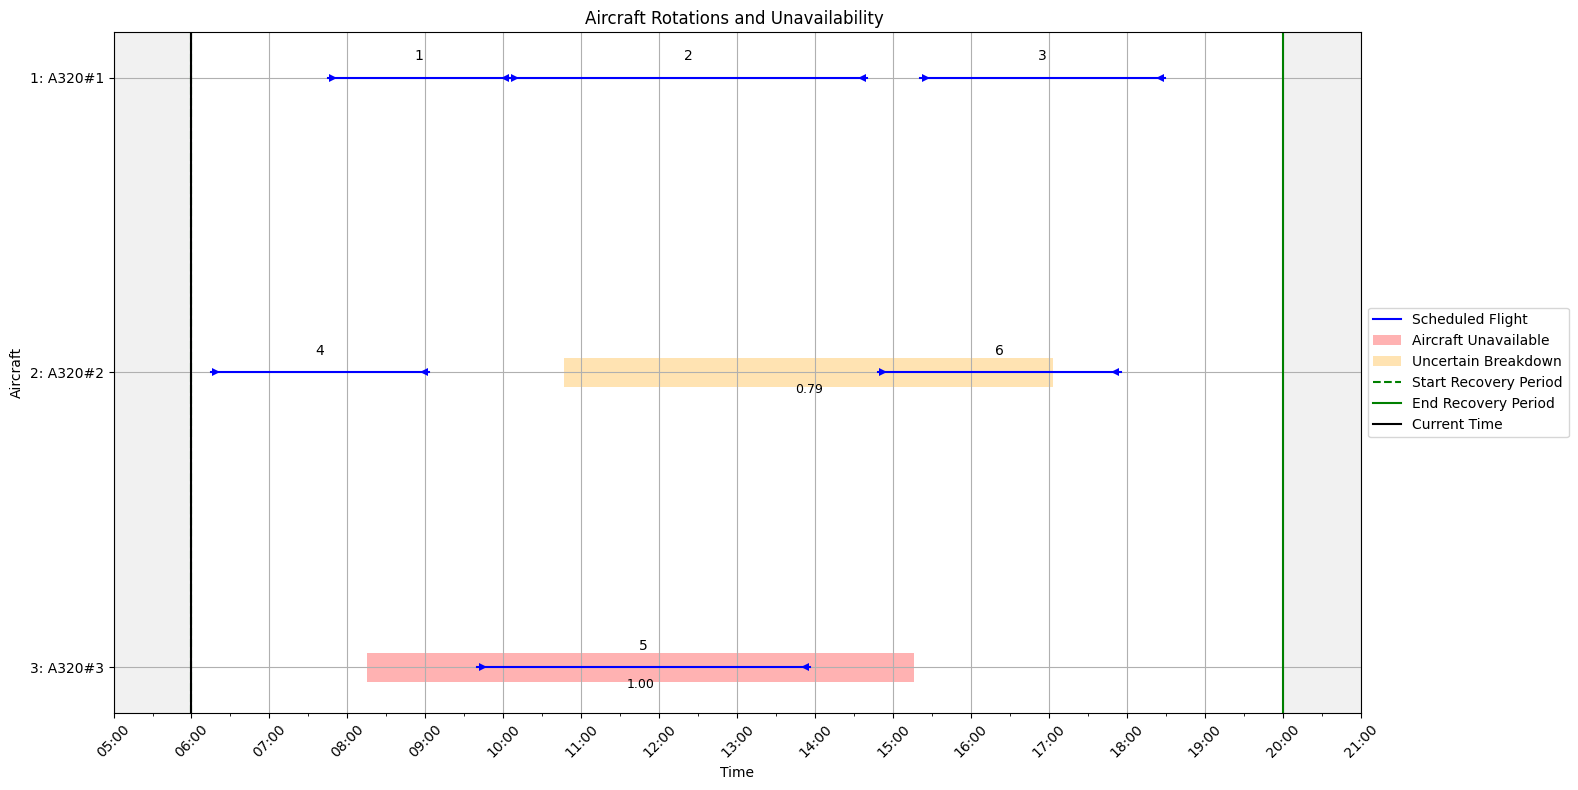

Processing scenario: Scenario_03
{'A320#3': {'StartDate': '19/09/24', 'StartTime': '11:34', 'EndDate': '19/09/24', 'EndTime': '14:39', 'Probability': 1.0}, 'A320#1': {'StartDate': '19/09/24', 'StartTime': '12:09', 'EndDate': '19/09/24', 'EndTime': '14:21', 'Probability': 0.58}}
│ Current Time       │ Time Until End     │   
│          0         │         960        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   0.58    369   501 |     6   374   535 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2      -      -     - |     4     0   134 |     5   192   315 |     7   540   696 |     8   755 

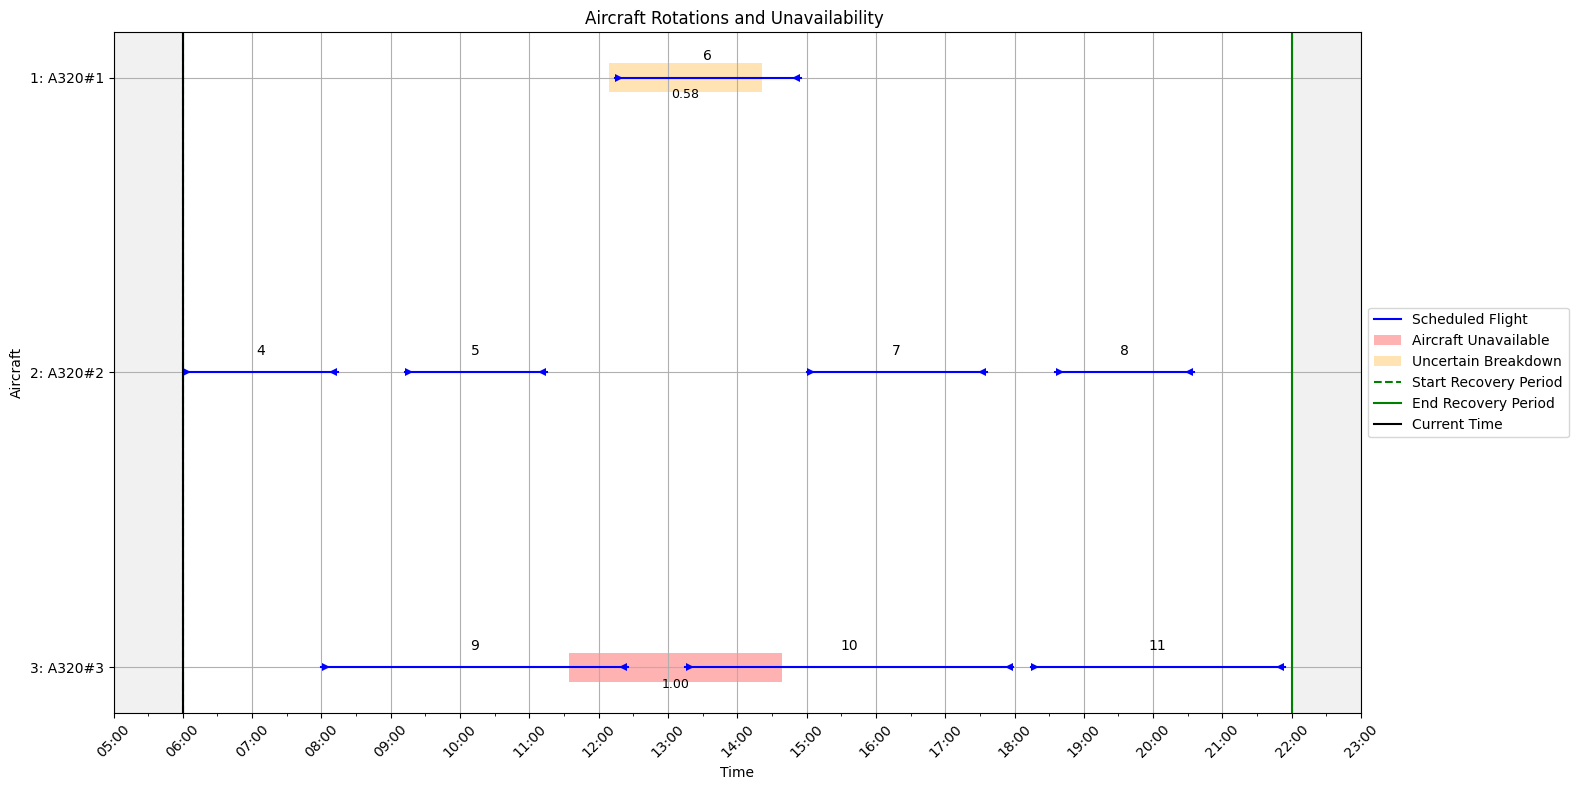

Processing scenario: Scenario_04
{'A320#2': {'StartDate': '25/09/24', 'StartTime': '12:53', 'EndDate': '25/09/24', 'EndTime': '20:46', 'Probability': 1.0}, 'A320#3': {'StartDate': '25/09/24', 'StartTime': '10:48', 'EndDate': '25/09/24', 'EndTime': '15:18', 'Probability': 0.89}}
│ Current Time       │ Time Until End     │   
│          0         │        1050        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     2   338   475 |     3   527   764 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00    473   946 |     4    75   352 |     5   355   576 |     6   592   799 |     -     - 

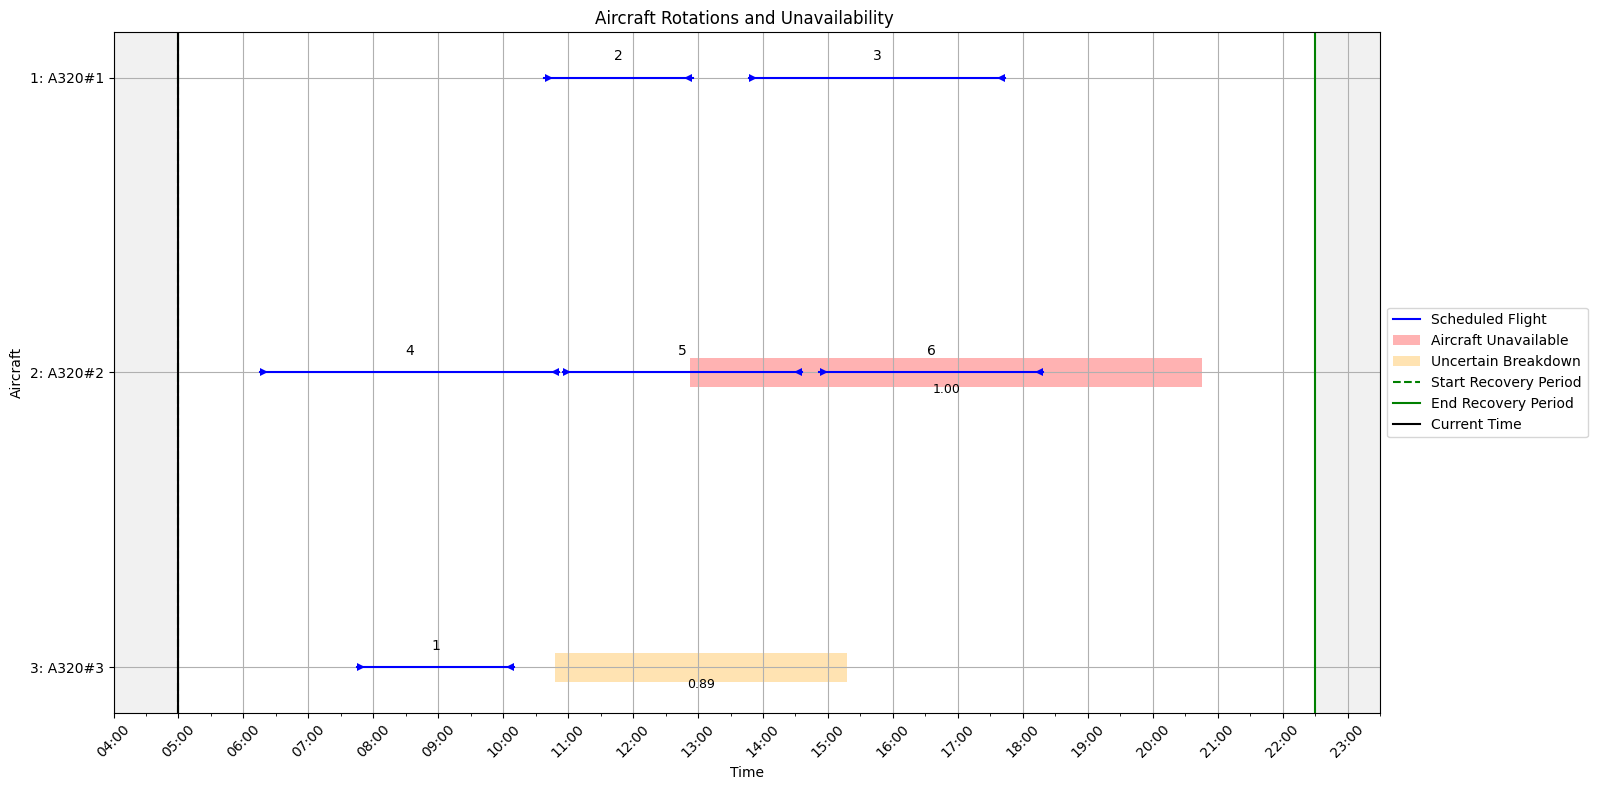

Processing scenario: Scenario_05
{'A320#2': {'StartDate': '26/09/24', 'StartTime': '14:26', 'EndDate': '26/09/24', 'EndTime': '20:26', 'Probability': 1.0}, 'A320#1': {'StartDate': '26/09/24', 'StartTime': '11:00', 'EndDate': '26/09/24', 'EndTime': '18:42', 'Probability': 0.68}}
│ Current Time       │ Time Until End     │   
│          0         │         840        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   0.68    240   702 |     1    60   282 |     2   306   532 |     3   536   766 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00    446   806 |     8   545   732 |     -     -     - |     -     -     - |     -     - 

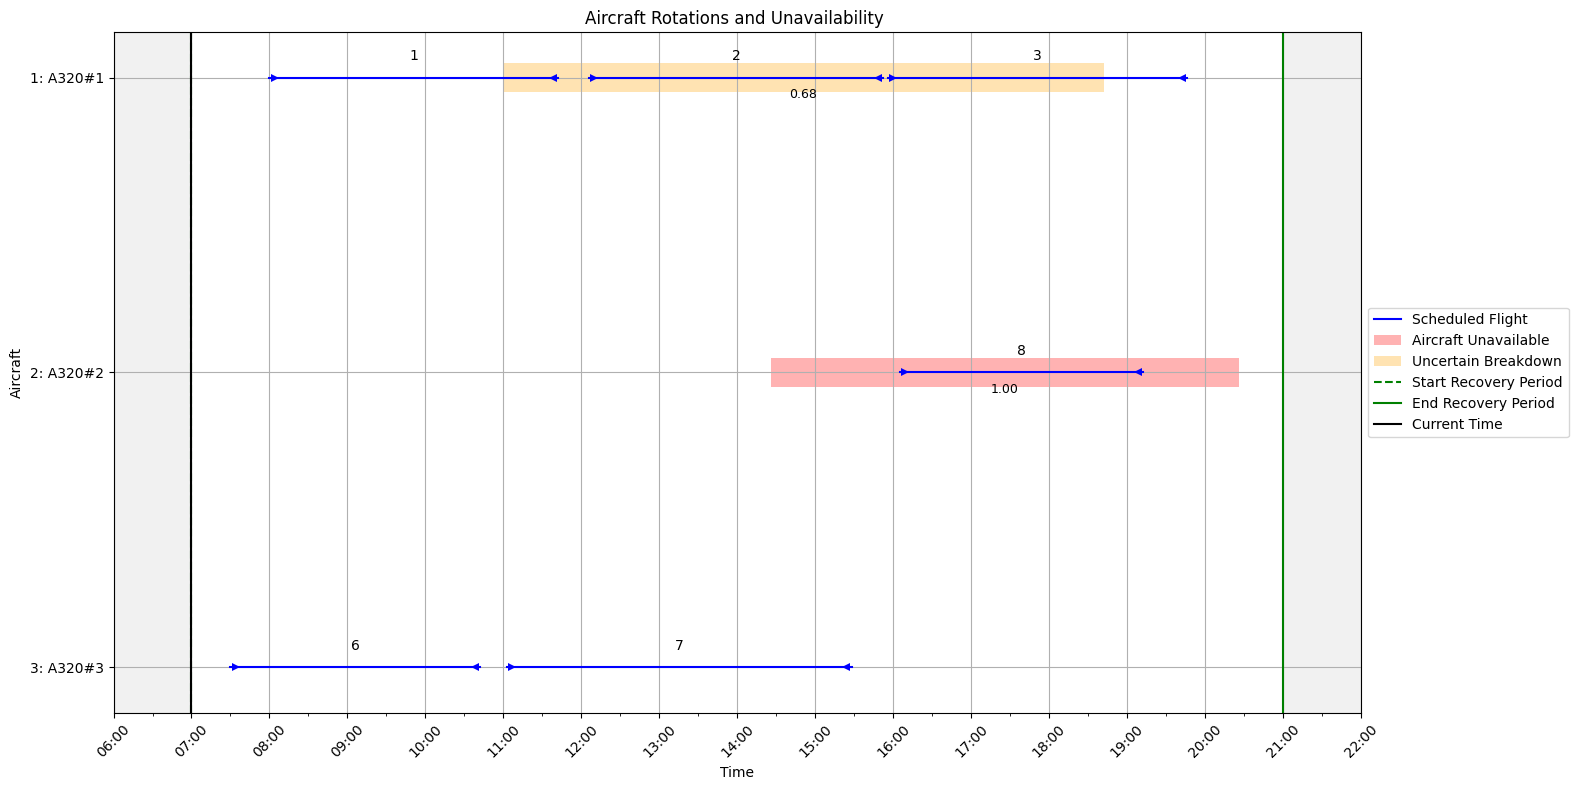

Processing scenario: Scenario_06
{'A320#2': {'StartDate': '24/09/24', 'StartTime': '12:02', 'EndDate': '24/09/24', 'EndTime': '17:15', 'Probability': 1.0}, 'A320#1': {'StartDate': '24/09/24', 'StartTime': '12:22', 'EndDate': '24/09/24', 'EndTime': '17:37', 'Probability': 0.77}}
│ Current Time       │ Time Until End     │   
│          0         │         810        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   0.77    322   637 |     1     0   163 |     2   222   354 |     3   384   628 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00    302   615 |     5   233   529 |     -     -     - |     -     -     - |     -     - 

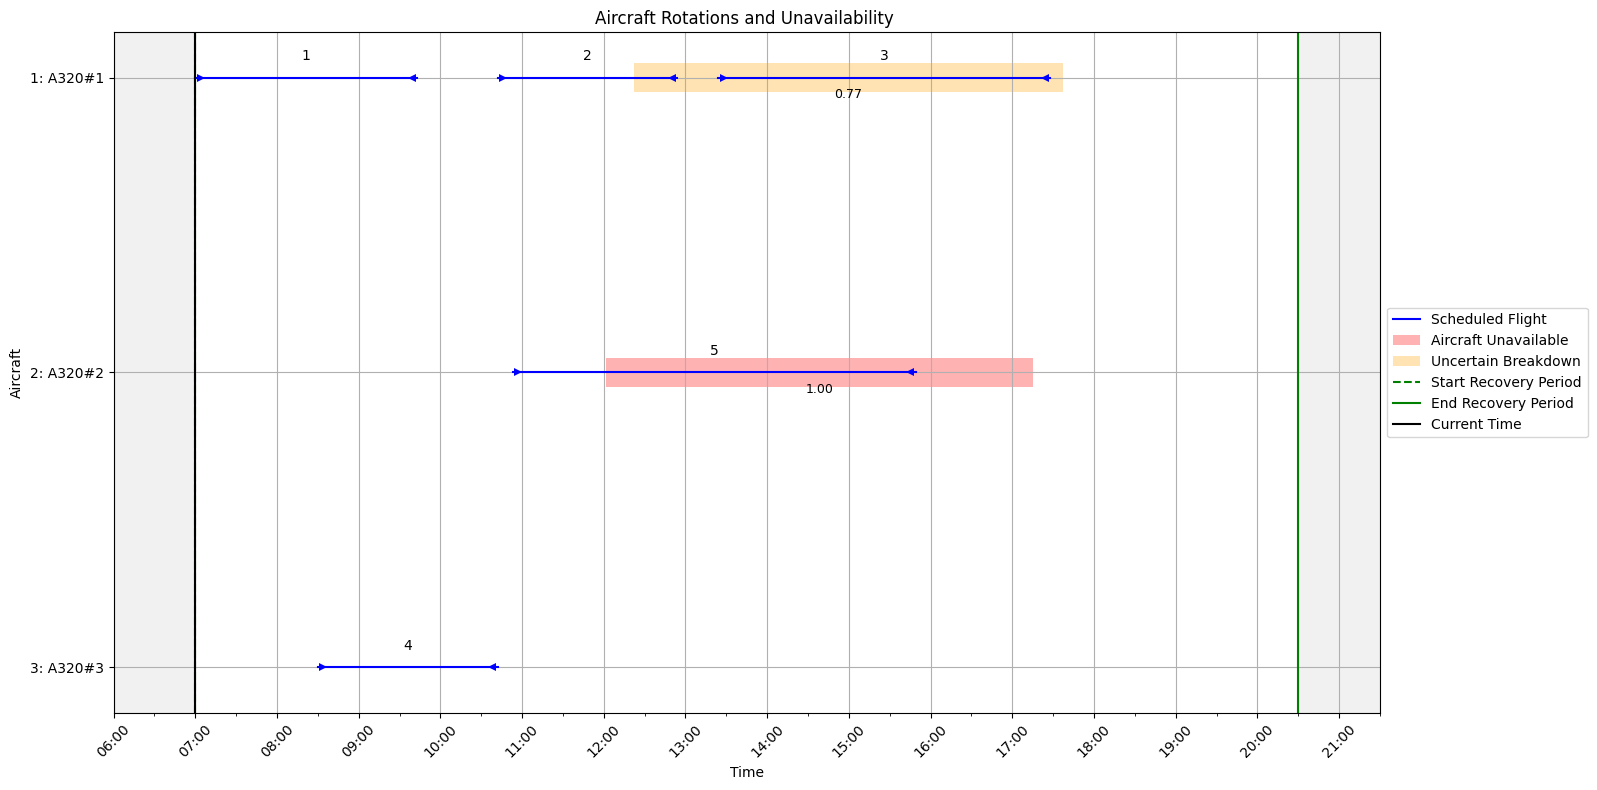

Processing scenario: Scenario_07
{'A320#1': {'StartDate': '14/09/24', 'StartTime': '13:51', 'EndDate': '14/09/24', 'EndTime': '18:44', 'Probability': 1.0}, 'A320#2': {'StartDate': '14/09/24', 'StartTime': '08:38', 'EndDate': '14/09/24', 'EndTime': '11:37', 'Probability': 0.86}}
│ Current Time       │ Time Until End     │   
│          0         │         840        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   1.00    471   764 |     1   120   345 |     2   390   584 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   0.86    158   337 |     6   333   478 |     -     -     - |     -     -     - |     -     - 

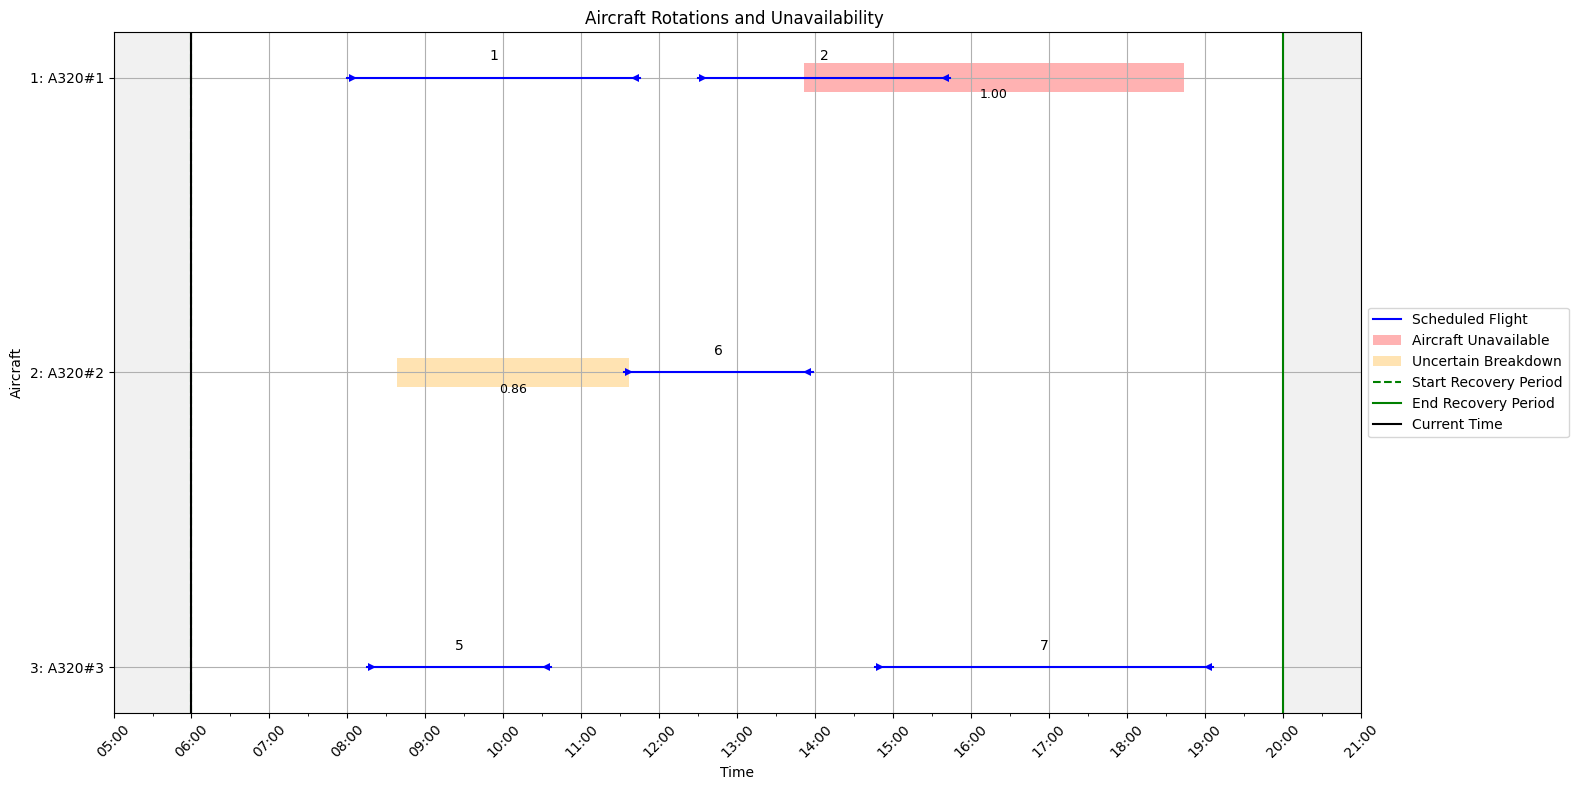

Processing scenario: Scenario_08
{'A320#3': {'StartDate': '03/09/24', 'StartTime': '14:48', 'EndDate': '03/09/24', 'EndTime': '21:28', 'Probability': 1.0}, 'A320#1': {'StartDate': '03/09/24', 'StartTime': '11:26', 'EndDate': '03/09/24', 'EndTime': '13:43', 'Probability': 0.86}}
│ Current Time       │ Time Until End     │   
│          0         │         990        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   0.86    266   403 |     1    75   323 |     2   367   542 |     3   586   794 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2      -      -     - |     4    75   272 |     6   531   722 |     7   744   866 |     -     - 

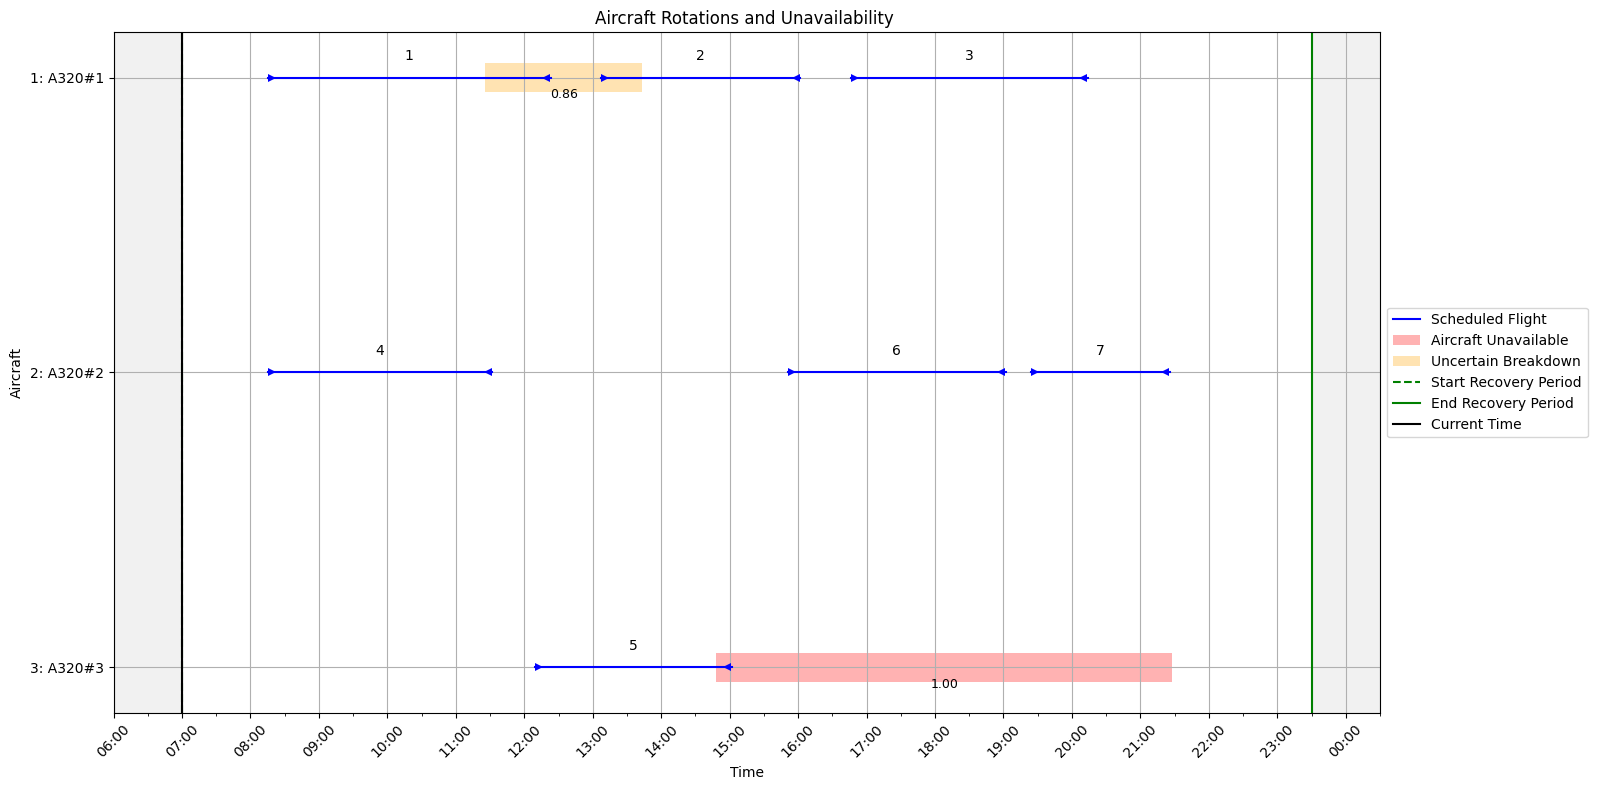

Processing scenario: Scenario_09
{'A320#3': {'StartDate': '28/09/24', 'StartTime': '12:34', 'EndDate': '28/09/24', 'EndTime': '17:53', 'Probability': 1.0}, 'A320#1': {'StartDate': '28/09/24', 'StartTime': '12:57', 'EndDate': '28/09/24', 'EndTime': '19:11', 'Probability': 0.63}}
│ Current Time       │ Time Until End     │   
│          0         │        1050        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   0.63    417   791 |     1    60   309 |     2   337   634 |     3   646   788 |     4   806   981 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2      -      -     - |     5   120   244 |     6   267   387 |     7   415   563 |     9   790 

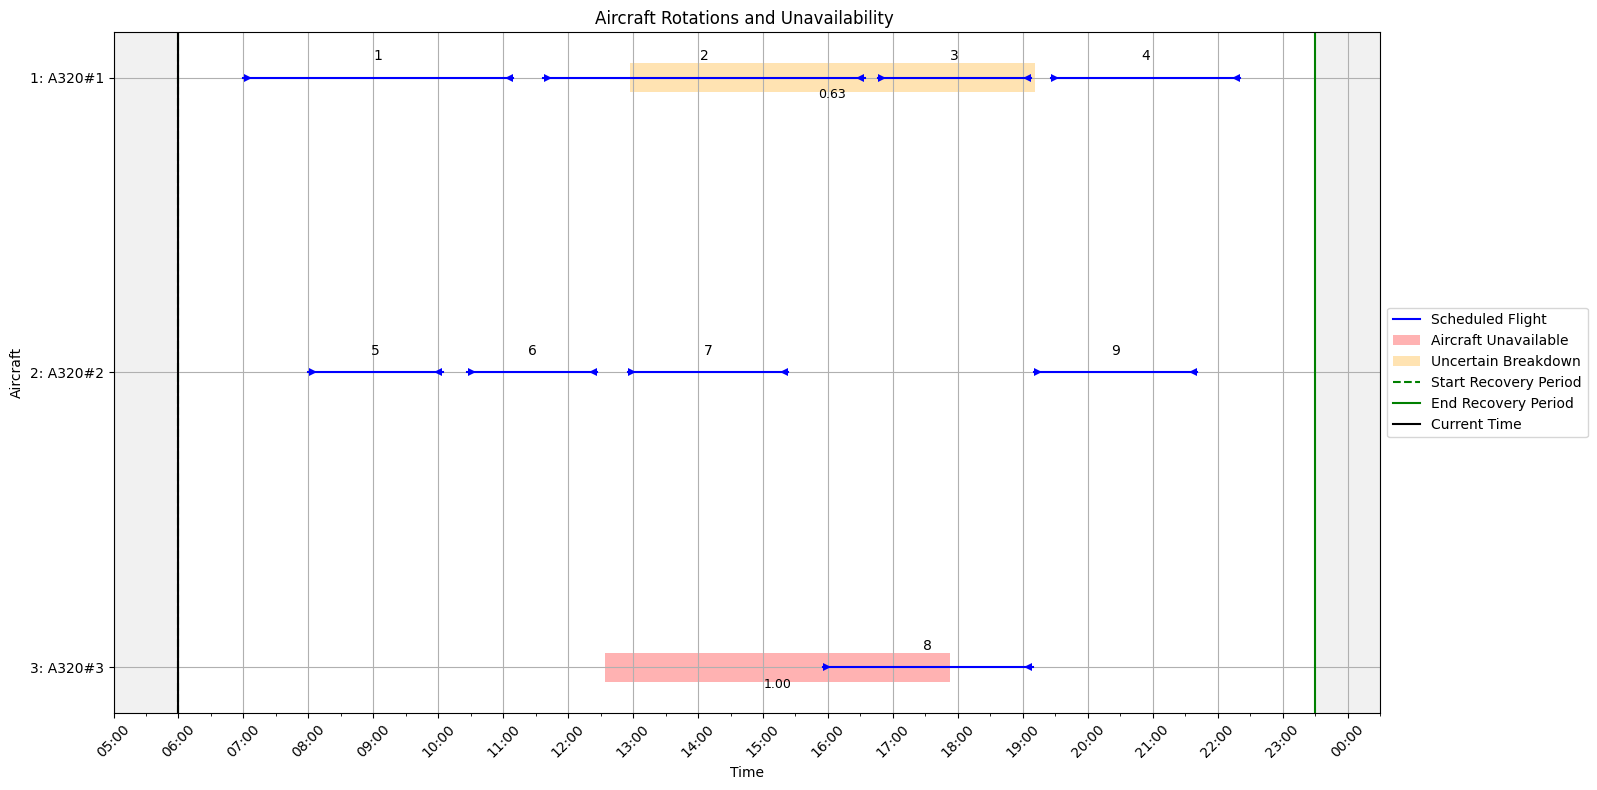

Processing scenario: Scenario_10
{'A320#2': {'StartDate': '27/09/24', 'StartTime': '11:06', 'EndDate': '27/09/24', 'EndTime': '15:07', 'Probability': 1.0}, 'A320#1': {'StartDate': '27/09/24', 'StartTime': '13:50', 'EndDate': '27/09/24', 'EndTime': '21:15', 'Probability': 0.7}}
│ Current Time       │ Time Until End     │   
│          0         │         900        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   0.70    410   855 |     1    15   260 |     3   457   639 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00    246   487 |     4    30   314 |     5   365   516 |     6   532   799 |     -     -  

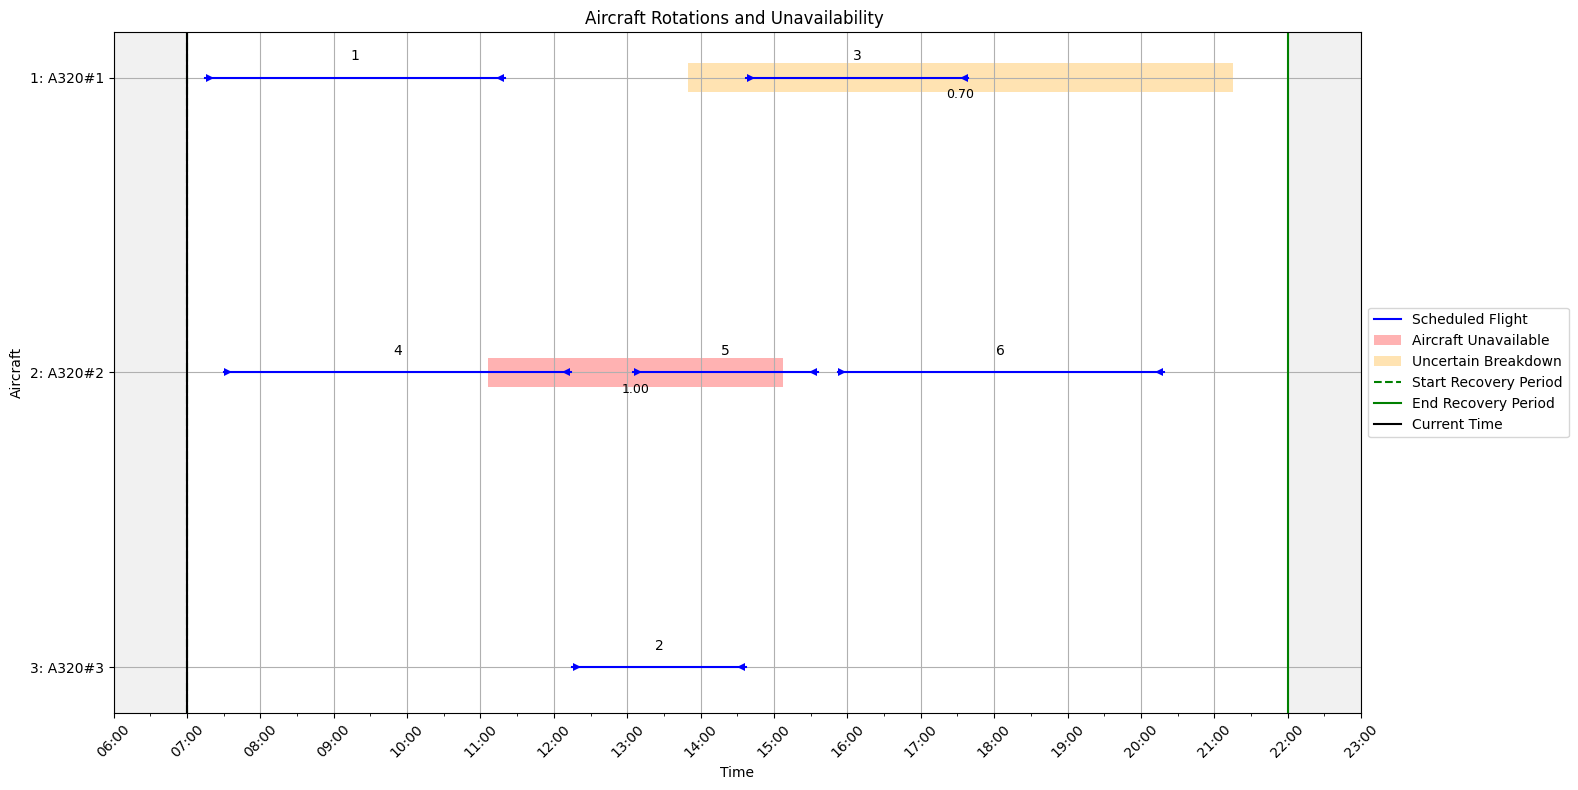

All scenarios processed successfully.


In [2]:
from scripts.visualizations import StatePlotter
from scripts.utils import load_scenario_data
import os
from src.environment import AircraftDisruptionEnv
from datetime import datetime
from scripts.utils import print_state_nicely_proactive

env_type = 'proactive'


# Verify that the root folder exists
if not os.path.exists(data_root_folder):
    raise FileNotFoundError(f"The data root folder does not exist: {data_root_folder}")

# Get the list of scenarios, sorted by name in ascending order
scenarios = sorted(
    [scenario for scenario in os.listdir(data_root_folder) if os.path.isdir(os.path.join(data_root_folder, scenario))]
)
plotter_counter = 0
# Process each scenario
for scenario_name in scenarios:
    plotter_counter += 1
    if plotter_counter > 10:
        break

    scenario_path = os.path.join(data_root_folder, scenario_name)
    
    print(f"Processing scenario: {scenario_name}")

    # Verify that the scenario exists
    if not os.path.exists(scenario_path):
        print(f"Scenario {scenario_name} does not exist. Skipping...")
        continue

    # Load scenario data
    data_dict = load_scenario_data(scenario_path)

    # Extract necessary data for the environment
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Print configuration details for verification
    # print(config_dict)

    # print alt_aircraft_dict
    print(alt_aircraft_dict)

    # Initialize the environment
    env = AircraftDisruptionEnv(
        aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict, env_type=env_type
    )
    # Print state with print_state_nicely_proactive
    print_state_nicely_proactive(env.state)
    
    # Create StatePlotter object for visualizing the environment state
    state_plotter = StatePlotter(
        aircraft_dict=env.aircraft_dict,
        flights_dict=env.flights_dict,
        rotations_dict=env.rotations_dict,
        alt_aircraft_dict=env.alt_aircraft_dict,
        start_datetime=env.start_datetime,
        end_datetime=env.end_datetime,
        uncertain_breakdowns=env.uncertain_breakdowns,
    )



    # Define the recovery period based on provided configuration
    start_date = config_dict['RecoveryPeriod']['StartDate']
    start_time = config_dict['RecoveryPeriod']['StartTime']
    end_date = config_dict['RecoveryPeriod']['EndDate']
    end_time = config_dict['RecoveryPeriod']['EndTime']
    start_datetime = datetime.strptime(f"{start_date} {start_time}", '%d/%m/%y %H:%M')

    # Plot the state for the current scenario
    print(f"Plotting state for scenario: {scenario_name}")
    state_plotter.plot_state(flights_dict, [], [], set(), env.current_datetime)

print("All scenarios processed successfully.")
